In [2]:
import os.path as osp
import numpy as np
import pickle as pkl
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from bindpredict.utils.rdkitutils import standardize
import seaborn as sns
import math
import matplotlib.pyplot as plt
from bindpredict.featuregen import Featurizer, create_X_Y
from bindpredict.utils.rdkitutils import smiles_to_mol
warnings.filterwarnings('ignore')
import os.path as osp

For this project I created a Python package called [bindpredict ](https://github.com/ndonyapour/bindpredict.git) which is available on GitHub. Please follow the installation instructions then you can run the codes.

## Data cleaning
In this part, I did the data cleaning. Some compounds binded to multiple categories of proteins in the dataset, so I deleted them from the dataset. Then I used RdKit to remove any smiles that is not correct and can not be sanitized.

In [3]:
compounds = pd.read_csv('data/smiles_l1.csv', sep=',')
compounds['L1_class_name'].value_counts()

['Enzyme']                                          701571
['Membrane receptor']                               236633
['Epigenetic regulator']                            104798
['Unclassified protein']                             98922
['Transcription factor']                             88341
['Ion channel']                                      66111
['Transporter']                                      43960
['Structural protein']                               37790
['Other cytosolic protein']                          36237
['Other membrane protein']                            8308
['Secreted protein']                                  6381
['Other nuclear protein']                             3995
['Surface antigen']                                   2046
['Adhesion']                                          1840
['Auxiliary transport protein']                        881
['Transcription factor', 'Transcription factor']        40
['Enzyme', 'Enzyme']                                    

In [4]:
# Remove compounds that have multiple category assigned
compounds = compounds[compounds['L1_class_name'].str.find(',') == -1]
compounds['L1_class_name'] = compounds.L1_class_name.apply(lambda x: x[2:-2])

In [5]:
curated_compounds_file_path = osp.realpath('data/curated_smiles_l1.csv')
if osp.exists(curated_compounds_file_path):
    curated_compounds = pd.read_csv(curated_compounds_file_path, sep=',')
else:
    # Check for invalid smiles
    validation_results = standardize(compounds['canonical_smiles'].values)
    # add these flags of being a valid or invalid compound to the dataset
    compounds.insert(loc=len(compounds.columns), column='Valid', value=validation_results) 
    curated_compounds = compounds[compounds['Valid'] == 'Yes']
    curated_compounds.to_csv('data/curated_smiles_l1.csv', sep=',', index=False)

## Visualize Statistics

Number of compounds =  1437814
Index(['canonical_smiles', 'L1_class_name', 'Valid'], dtype='object')
Enzyme                         701571
Membrane receptor              236633
Epigenetic regulator           104798
Unclassified protein            98922
Transcription factor            88341
Ion channel                     66111
Transporter                     43960
Structural protein              37790
Other cytosolic protein         36237
Other membrane protein           8308
Secreted protein                 6381
Other nuclear protein            3995
Surface antigen                  2046
Adhesion                         1840
Auxiliary transport protein       881
Name: L1_class_name, dtype: int64
The distributions of data 
                 canonical_smiles L1_class_name    Valid
count                     1437814       1437814  1437814
unique                    1437814            15        1
top     B.CP(c1ccccc1)c1ccc(O)cc1        Enzyme      Yes
freq                            1       

[Text(0, 0, 'Transcription factor'),
 Text(1, 0, 'Membrane receptor'),
 Text(2, 0, 'Enzyme'),
 Text(3, 0, 'Other nuclear protein'),
 Text(4, 0, 'Unclassified protein'),
 Text(5, 0, 'Transporter'),
 Text(6, 0, 'Other cytosolic protein'),
 Text(7, 0, 'Epigenetic regulator'),
 Text(8, 0, 'Structural protein'),
 Text(9, 0, 'Ion channel'),
 Text(10, 0, 'Other membrane protein'),
 Text(11, 0, 'Surface antigen'),
 Text(12, 0, 'Secreted protein'),
 Text(13, 0, 'Adhesion'),
 Text(14, 0, 'Auxiliary transport protein')]

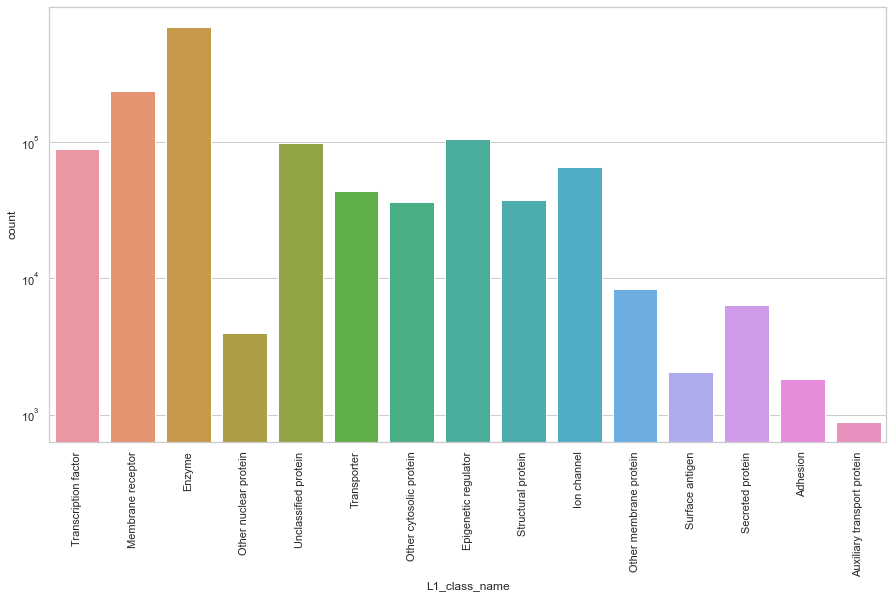

In [6]:
print("Number of compounds = ", curated_compounds.shape[0])
print(curated_compounds.columns)
print(curated_compounds['L1_class_name'].value_counts())
print("The distributions of data ")
print(curated_compounds.describe())
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15, 8))
ax = sns.countplot(x="L1_class_name", data=curated_compounds, log=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

This bar graph shows that we have a highly imbalanced dataset where classes are not represented equally, making classification very challenging. We need to use undersampling or oversampling algorithms for classification to mitigate this isuue.

## Generate features 
Lipinski's rule of five determines whether a compound can be an oral drug. Considering these rules, I defined seven types of physicochemical properties, including partition coefficient (logP), the number of hydrogen-bond donors and acceptors, the polar surface area (PSA), molecular weight, the number of rings, and the number of rotatable bonds. Further, I generated two sets of widely-used molecular fingerprints, ECFP4 and MACCS, for the compounds in the dataset. The combination of molecular physicochemical properties and fingerprints comprise the features that were used for training.

In [7]:
compound_features_pkl_path = osp.realpath('data/smiles_l1_features.pkl')
if osp.exists(compound_features_pkl_path):
    with open(compound_features_pkl_path, 'rb') as rfile:
        curated_compounds = pkl.load(rfile)
else:
    compound_smiles = curated_compounds['canonical_smiles'].values
    mols = smiles_to_mol(compound_smiles)
    mol_featurizer = Featurizer()
    features = mol_featurizer.generate(mols)
    for key in features.keys():
        curated_compounds.insert(loc=len(curated_compounds.columns), 
                                 column=key, 
                                 value=features[key])
    with open('data/smiles_l1_features.pkl', 'wb') as wfile:
        pkl.dump(curated_compounds, wfile)

In [10]:
print(curated_compounds.columns)

Index(['canonical_smiles', 'L1_class_name', 'Valid', 'LogP', 'MolWt', 'PSA',
       'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'RingCount',
       'ECPF4', 'MACCS'],
      dtype='object')


## Create the test set
For training the classification model, I employed a stratified train-test split method to ensure the test set has the same proportions of compounds in each class as observed in the original dataset. Since the dataset is highly imbalanced, I tried to do the imbalanced classification using two different methods.

In [ ]:
feature_keys = ['LogP', 'MolWt', 'PSA', 'NumHAcceptors', 'NumHDonors',
                'NumRotatableBonds', 'RingCount', 'ECPF4', 'MACCS']
X, Y = create_X_Y(curated_compounds, feature_keys, 'L1_class_name')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y,
                                                    test_size=0.1,
                                                     random_state=42)

### Method 1
For the first approach, I used Tomek Links and the Edited Nearest Neighbors (ENN) undersampling methods from the `imbalanced-learn` to delete compounds from the majority class, such as Enzyme and Membrane receptors classes. Tomek Links finds the closest molecules in the majority class to the minority class and then removes them. Essentially, the ENN method removes samples close to the decision boundary between two classes. For doing so, I submitted a job with 100G of memory and 40 CPUs on our high-performance system (HPCC) nodes, but it failed after 18 hours.


In [ ]:
from imblearn.under_sampling import TomekLinks
from collections import Counter
from imblearn.under_sampling import EditedNearestNeighbours

undersampler = TomekLinks(n_jobs=-1)
print('Original dataset shape %s' % Counter(y_train))

X_res, y_res = undersampler.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


undersample = EditedNearestNeighbours(n_neighbors=3, n_jobs=-1)
X_res2, y_res2 = undersample.fit_resample(X_res, y_res)

with open('../data/train_data_us2.pkl', 'wb') as wfile:
    pkl.dump([X_res2, y_res2], wfile)
print('Resampled dataset shape %s' % Counter(y))

### Method 2
For the second approach, my idea was to cluster the majority of class compounds using the Taylor-Butina clustering algorithm and randomly select molecules from each cluster to create a category with 5000 compounds. Then, I could apply the SMOTEENN sampling method to train a `BalancedBaggingClassifier` classifier. The training code can be found in the `modeling.py` module. Unfortunately, even with 200GB of memory, clustering failed after 30 minutes, and thus I could not train any model using this method. Also, note that the Taylor-Butina clustering algorithm needs to be implemented in a way that allows for mini-batch clustering. Nevertheless, this would take some time beyond the deadline of this project.

In [ ]:
from bindpredict.utils.rdkitutils import ClusterFps, np_to_bv

df = curated_compounds[curated_compounds['L1_class_name'] == 'Enzyme']

cutoff = 0.5

fps = []

for fv in df['ECPF4'].values:
    fps.append(np_to_bv(fv))

print("Start Clustering")

clusters = ClusterFps(fps,
                      cutoff=cutoff)
pkl.dump(clusters, open('../data/cluster_Enzyme.pkl', 'wb'))

clusters = sorted(clusters, key=lambda x: -len(x))
singletons = [x for x in clusters if len(x) == 1]
print('Num of clusters=', len(clusters))
print('Num of singleton clusters=', len(singletons))


### Method 3
I did clasification without any sampling. The codes are available in the second jupyter notebook (step2_train_model.ipynb).